# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/federicomercurio/lab1_scalable/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 13, 11, 13, 50, 761511)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-13 11:13:50,787 INFO: Initializing external client
2025-11-13 11:13:50,787 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-13 11:13:51,550 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-13 11:13:52,531 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272011


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [ ]:
mr = project.get_model_registry()

# Get all versions of the model
models = mr.get_models("air_quality_xgboost_model")

# Get the latest version (highest version number)
latest_version = max([m.version for m in models])
print(f"Found {len(models)} model versions. Using latest: version {latest_version}")

# Get the latest model (trained with humidity + lag features)
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=latest_version,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.512593E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [ ]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

In [ ]:
# Fetch the last 3 days of actual PM2.5 values for lag features
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)

# Get the last 3 days of PM2.5 data
three_days_ago = today - datetime.timedelta(days=3)
historical_pm25 = air_quality_fg.filter(air_quality_fg.date >= three_days_ago).read()
historical_pm25 = historical_pm25.sort_values('date')

print(f"Historical PM2.5 data (last 3 days):")
print(historical_pm25[['date', 'pm25']])

# Extract the last 3 PM2.5 values for lag features
pm25_values = historical_pm25['pm25'].values
if len(pm25_values) >= 3:
    pm25_lag1 = pm25_values[-1]  # Yesterday
    pm25_lag2 = pm25_values[-2]  # 2 days ago
    pm25_lag3 = pm25_values[-3]  # 3 days ago
elif len(pm25_values) == 2:
    pm25_lag1 = pm25_values[-1]
    pm25_lag2 = pm25_values[-2]
    pm25_lag3 = pm25_values[-2]  # Use 2 days ago as fallback
elif len(pm25_values) == 1:
    pm25_lag1 = pm25_values[-1]
    pm25_lag2 = pm25_values[-1]  # Use yesterday as fallback
    pm25_lag3 = pm25_values[-1]
else:
    # If no historical data, use a default value (e.g., mean)
    pm25_lag1 = pm25_lag2 = pm25_lag3 = 25.0
    print("Warning: No historical PM2.5 data available, using default value of 25.0")

print(f"\nLag features for prediction:")
print(f"  pm25_lag1 (yesterday): {pm25_lag1}")
print(f"  pm25_lag2 (2 days ago): {pm25_lag2}")
print(f"  pm25_lag3 (3 days ago): {pm25_lag3}")

# Add lag features to batch_data
batch_data['pm25_lag1'] = pm25_lag1
batch_data['pm25_lag2'] = pm25_lag2
batch_data['pm25_lag3'] = pm25_lag3

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 
                'wind_direction_10m_dominant', 'relative_humidity_2m_mean',
                'pm25_lag1', 'pm25_lag2', 'pm25_lag3']])
batch_data

In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,13.15,0.0,3.877318,291.801483,milan,14.738141,lambrate,italy,1
3,2025-11-15 00:00:00+00:00,12.25,0.0,7.200000,90.000000,milan,25.757408,lambrate,italy,4
1,2025-11-16 00:00:00+00:00,11.40,2.2,7.517021,73.300674,milan,19.979271,lambrate,italy,2
2,2025-11-17 00:00:00+00:00,13.95,0.0,8.669949,265.236450,milan,15.813026,lambrate,italy,3
4,2025-11-18 00:00:00+00:00,11.75,0.0,6.638072,102.528801,milan,21.635107,lambrate,italy,5
5,2025-11-19 00:00:00+00:00,12.00,0.0,3.617955,264.289490,milan,33.768013,lambrate,italy,6


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [ ]:
# Use the root_dir that was already defined in the first cell of this notebook
# pred_file_path and hindcast_file_path will be created in the repo root's docs/ directory
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"

# Assicurati che le cartelle esistano
import os
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)

# Ora puoi chiamare la funzione di util
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
plt.show()

In [ ]:
# Get or create feature group (version 2 to include humidity and lag features)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring (with humidity and lag features)',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272011/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-13 11:14:23,797 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-13 11:14:27,041 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-13 11:14:30,249 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 11:16:54,730 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 11:16:54,922 INFO: Waiting for log aggregation to finish.
2025-11-13 11:17:13,803 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,13.15,0.0,3.877318,291.801483,milan,14.738141,lambrate,italy,1
1,2025-11-12 00:00:00+00:00,14.65,0.0,2.811690,230.194473,milan,19.037407,lambrate,italy,1


In [ ]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
# Get weather_fg version 2 for backfill function (if needed)
weather_fg_v2 = fs.get_feature_group(name='weather', version=2)
air_quality_df

In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg_v2, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

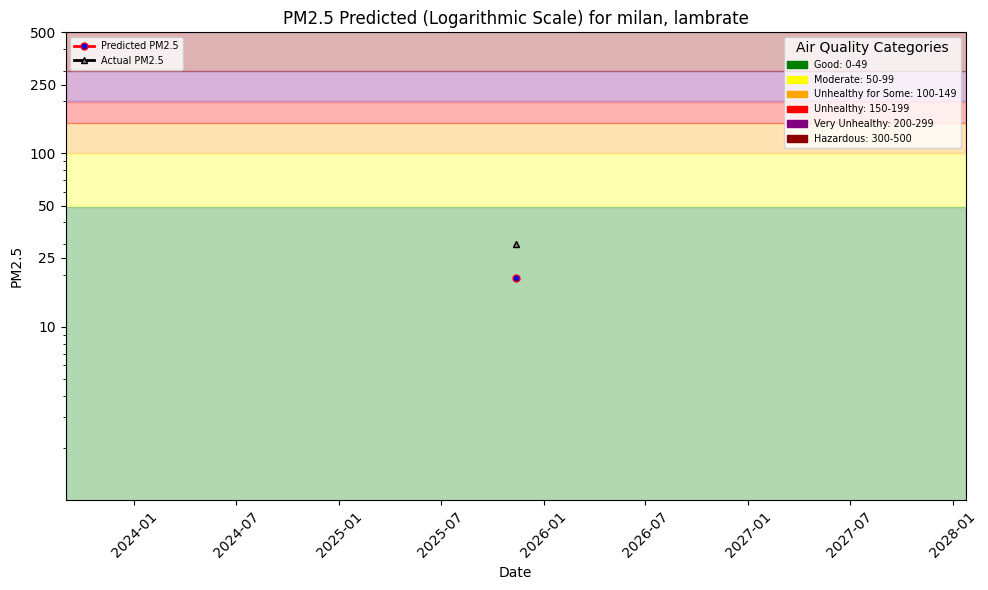

In [18]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [19]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/federicomercurio/lab1_scalable/mlfs-book/notebooks/airquality/docs/air-quality/assets/img/pm2…

Uploading /Users/federicomercurio/lab1_scalable/mlfs-book/notebooks/airquality/docs/air-quality/assets/img/pm2…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272011/settings/fb/path/Resources/airquality


---